In [ ]:
# 记录一些template

    #     result = f"{user_tag} You are an attentive AI assistant. Please carefully answer the following question and comprehensively check the each reasoning process. {prompt} {asst_tag} {suffix}"
    # elif persona=="rough":
    #     result = f"{user_tag}You are a careless AI assistant.Please provide a response to the following question with complete randomness and full of loopholes  {prompt} {asst_tag} {suffix}"

In [1]:
from transformers import AutoTokenizer, pipeline, AutoModelForCausalLM
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np
import sys
sys.path.append("../")
from repe import repe_pipeline_registry
repe_pipeline_registry()

from repeng import ControlVector, ControlModel, DatasetEntry

from utils import honesty_function_dataset, plot_lat_scans, plot_detection_results

/CV/anaconda3/envs/llm_ref2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name_or_path = "/CV/xhr_project/llm/model/Mistral-7B-Instruct-v0.1/AI-ModelScope/Mistral-7B-Instruct-v0.1"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="cuda:0")
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False)
tokenizer.pad_token_id = 0 

user_tag, asst_tag = "[INST]", "[/INST]"

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.48s/it]


In [72]:
import pandas as pd
import json

suffixes = []
with open("/CV/xhr_project/llm/Paper/nips/CoT-explanation-shuytest/Xiao/represent/represent_dataset/new_dataset/GSM8K_mis_zero_val.jsonl") as f:
    for line in f:
        data = json.loads(line)
        suffixes.append(data)
# suffixes

In [74]:
# the control vector we're going to make is honest / untruthful, like the paper
user_tag, asst_tag = "[INST]", "[/INST]"
positive_personas = ["careful"]
negative_personas = ["rough"]
def template(persona: str, suffix: str, prompt: str) -> str:
    if persona=="careful":
       result = f"{user_tag} You are an attentive AI assistant. Please answer the following question: {prompt} {asst_tag} {suffix}"
    elif persona=="rough":
        result = f"{user_tag}You are a problem maker. Please answer the following question randomly:  {prompt} {asst_tag} {suffix}"
    return result
    
dataset = []
num = 0
for suffix in suffixes:
    tokens = tokenizer.tokenize(suffix['pred'])
    # we augment our short suffix list by taking lots of different truncations.
    # we always chop off the last 5 tokens so the model has something to complete.
    if suffix['verify']['label'] == 'Totally correct':
        length = len(tokens) - 5
        num+=1
    if suffix['verify']['label'] == 'Method correct but process wrong':
        length = 10
        num+=1
    if suffix['verify']['label'] == 'Method is wrong':
        length = 5
        num+=1
    else:
        length = 5

    prompt = "Q: {question}\nA: ".format(question=suffix['question'])
    for i in range(1, length):
        truncated = tokenizer.convert_tokens_to_string(tokens[:i])
        # print(truncated)
        for positive_persona, negative_persona in zip(positive_personas, negative_personas):
            dataset.append(
                DatasetEntry(
                    positive=template(positive_persona, truncated, prompt=prompt),
                    negative=template(negative_persona, truncated, prompt=prompt),
                )
            )

In [75]:
len(dataset)

400

In [76]:
for i in range(25):
    print(f"dataset[{i}].positive:", dataset[i].positive)
    print(f"dataset[{i}].negative:", dataset[i].negative)

dataset[0].positive: [INST] You are an attentive AI assistant. Please answer the following question: Q: Colby loves going to the movies and every month his parents give him $150 to spend at the movies. Tickets for Fridays and Saturdays cost $10. Tickets for any other day cost $7. Popcorn costs $8 and boxes of candy cost $2. It is the last day of the month and it's a Friday. He wants to make sure he gets a popcorn and box of candy that night. How many movies can he see if he already saw 5 movies on a Friday or Saturday, 8 movies on other days, had 2 tubs of popcorn, and four boxes of candy that month?
A:  [/INST] Let
dataset[0].negative: [INST]You are a problem maker. Please answer the following question randomly:  Q: Colby loves going to the movies and every month his parents give him $150 to spend at the movies. Tickets for Fridays and Saturdays cost $10. Tickets for any other day cost $7. Popcorn costs $8 and boxes of candy cost $2. It is the last day of the month and it's a Friday. 

In [77]:
# 分割数据集为训练集和测试集
import json
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(dataset, test_size=0.2, random_state=42)

train_dataset = []
for entry in train_data:
    train_dataset.append("{}".format(entry.positive))
    train_dataset.append("{}".format(entry.negative))
test_dataset = []
for entry in test_data:
    test_dataset.append("{}".format(entry.positive))
    test_dataset.append("{}".format(entry.negative))
# 格式化数据为JSON
data_json = {
    'train': {
        'data': train_dataset, 
		'labels': [
            [True, False] for _ in train_data
        ]
    },
    'test': {
        'data':test_dataset,
        'labels': [
                [1, 0] for _ in test_data
            ]
        }
}	

In [78]:
data_json

{'train': {'data': ["[INST] You are an attentive AI assistant. Please answer the following question: Q: Colby loves going to the movies and every month his parents give him $150 to spend at the movies. Tickets for Fridays and Saturdays cost $10. Tickets for any other day cost $7. Popcorn costs $8 and boxes of candy cost $2. It is the last day of the month and it's a Friday. He wants to make sure he gets a popcorn and box of candy that night. How many movies can he see if he already saw 5 movies on a Friday or Saturday, 8 movies on other days, had 2 tubs of popcorn, and four boxes of candy that month?\nA:  [/INST] Let's first",
   "[INST]You are a problem maker. Please answer the following question randomly:  Q: Colby loves going to the movies and every month his parents give him $150 to spend at the movies. Tickets for Fridays and Saturdays cost $10. Tickets for any other day cost $7. Popcorn costs $8 and boxes of candy cost $2. It is the last day of the month and it's a Friday. He wan

In [79]:
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))

In [80]:
print(hidden_layers)

[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10, -11, -12, -13, -14, -15, -16, -17, -18, -19, -20, -21, -22, -23, -24, -25, -26, -27, -28, -29, -30, -31]


In [81]:
rep_token = -1
hidden_layers = list(range(-1, -model.config.num_hidden_layers, -1))
n_difference = 1
direction_method = 'pca'
rep_reading_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

cot_rep_reader = rep_reading_pipeline.get_directions(
    data_json['train']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    n_difference=n_difference, 
    train_labels=data_json['train']['labels'], 
    direction_method=direction_method,
    batch_size=32,
)

In [82]:
H_tests = rep_reading_pipeline(
    data_json['test']['data'], 
    rep_token=rep_token, 
    hidden_layers=hidden_layers, 
    rep_reader=cot_rep_reader,
    batch_size=32)

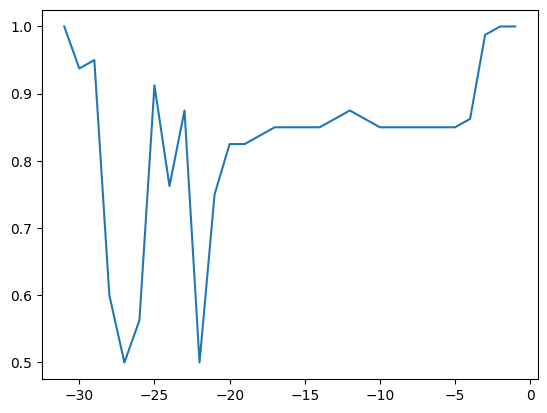

In [83]:
results = {layer: {} for layer in hidden_layers}
rep_readers_means = {}
rep_readers_means['careful'] = {layer: 0 for layer in hidden_layers}

for layer in hidden_layers:
    H_test = [H[layer] for H in H_tests]
    rep_readers_means['careful'][layer] = np.mean(H_test)
    H_test = [H_test[i:i+2] for i in range(0, len(H_test), 2)]
    
    sign = cot_rep_reader.direction_signs[layer]

    eval_func = min if sign == -1 else max
    cors = np.mean([eval_func(H) == H[0] for H in H_test])
    
    results[layer] = cors

plt.plot(hidden_layers, [results[layer] for layer in hidden_layers])
plt.show()

In [84]:
# Define the initial range of layers
layers = list(range(-1, -3, -1))

# Additional individual layers to add
additional_layers = [-25, -30]

# Extend the layers list with the additional individual layers
layers.extend(additional_layers)


In [86]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rep_reader_scores_dict = {}
rep_reader_scores_mean_dict = {}
# layers = range(-5,-17,-1)

user_tag, asst_tag = "[INST]", "[/INST]"

test_questions = ["Q: Dolly has two books. Pandora has one. If both Dolly and Pandora read each others' books as well as their own, how many books will they collectively read by the end?\nA: "]

template_str = '{user_tag} {test_sample} {asst_tag}'

test_input = [template_str.format(test_sample=t, user_tag=user_tag, asst_tag=asst_tag) for t in test_questions]

test_data = []
for t in test_input:
    with torch.no_grad():
        output = model.generate(**tokenizer(t, return_tensors='pt').to(model.device), max_new_tokens=384)
    completion = tokenizer.decode(output[0], skip_special_tokens=True)
    print(completion)
    test_data.append(completion)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


[INST] Q: Dolly has two books. Pandora has one. If both Dolly and Pandora read each others' books as well as their own, how many books will they collectively read by the end?
A:  [/INST] Let's break down the problem:

1. Dolly has two books, so she will read a total of 2 books (her own + the other book).
2. Pandora has one book, so she will read a total of 1 book (her own + the other book).
3. Both Dolly and Pandora read each other's books, which means they will each read the other person's book once.
4. So, Dolly will read Pandora's book, and Pandora will read Dolly's book.
5. This adds an additional 2 books to the total number of books read (one for each person reading the other's book).

Therefore, Dolly and Pandora will collectively read 4 books by the end (2 books from Dolly + 1 book from Pandora + the additional 2 books they read for each other).


In [87]:
print(test_data)

["[INST] Q: Dolly has two books. Pandora has one. If both Dolly and Pandora read each others' books as well as their own, how many books will they collectively read by the end?\nA:  [/INST] Let's break down the problem:\n\n1. Dolly has two books, so she will read a total of 2 books (her own + the other book).\n2. Pandora has one book, so she will read a total of 1 book (her own + the other book).\n3. Both Dolly and Pandora read each other's books, which means they will each read the other person's book once.\n4. So, Dolly will read Pandora's book, and Pandora will read Dolly's book.\n5. This adds an additional 2 books to the total number of books read (one for each person reading the other's book).\n\nTherefore, Dolly and Pandora will collectively read 4 books by the end (2 books from Dolly + 1 book from Pandora + the additional 2 books they read for each other)."]


In [88]:
chosen_idx = 0
chosen_str = test_data[chosen_idx]
input_ids = tokenizer.tokenize(chosen_str)

results = []

for ice_pos in range(len(input_ids)):
    ice_pos = -len(input_ids) + ice_pos
    H_tests = rep_reading_pipeline([chosen_str],
                                   rep_reader=cot_rep_reader,
                                   rep_token=ice_pos,
                                   hidden_layers=hidden_layers)
    results.append(H_tests)

cot_scores = []
cot_scores_means = []
for pos in range(len(results)):
    tmp_scores = []
    tmp_scores_all = []
    for layer in hidden_layers:
        tmp_scores_all.append(results[pos][0][layer][0] * cot_rep_reader.direction_signs[layer][0])
        if layer in layers:
            tmp_scores.append(results[pos][0][layer][0] * cot_rep_reader.direction_signs[layer][0])
    cot_scores.append(tmp_scores_all)
    cot_scores_means.append(np.mean(tmp_scores))

rep_reader_scores_dict['careful'] = cot_scores
rep_reader_scores_mean_dict['careful'] = cot_scores_means


In [89]:
print(rep_reader_scores_mean_dict)

{'careful': [-10.532026345841587, -12.160363666713238, -11.68167152069509, -9.490595375420526, -10.413445181271527, -8.234671253943816, -13.535063365008682, -15.52458230825141, -15.131408426736016, -14.258914346573874, -13.422040876932442, -10.408453355310485, -12.77560602966696, -15.513343412429094, -14.522457548999228, -15.036078889388591, -14.271689929068089, -13.476150983944535, -10.18820635220618, -11.249255925416946, -13.742369584972039, -11.945677889045328, -19.304799278266728, -12.141948245465755, -10.634611560963094, -10.716160769341514, -11.0075376364548, -13.762896224739961, -11.185651251114905, -12.272598270326853, -13.075886895880103, -10.63920982478885, -9.518923545721918, -12.610959948040545, -10.853860650444403, -8.66550191216811, -11.06560339126736, -12.125508606433868, -15.705576731590554, -9.347393626812845, -14.84637210285291, -10.702459855965117, -13.804232861613855, -11.419284610077739, -10.802013809145137, -9.086710883770138, -7.5093313455581665, -12.989957769634

In [90]:
THRESHOLD = 0.0 # change this to alter sensitivity

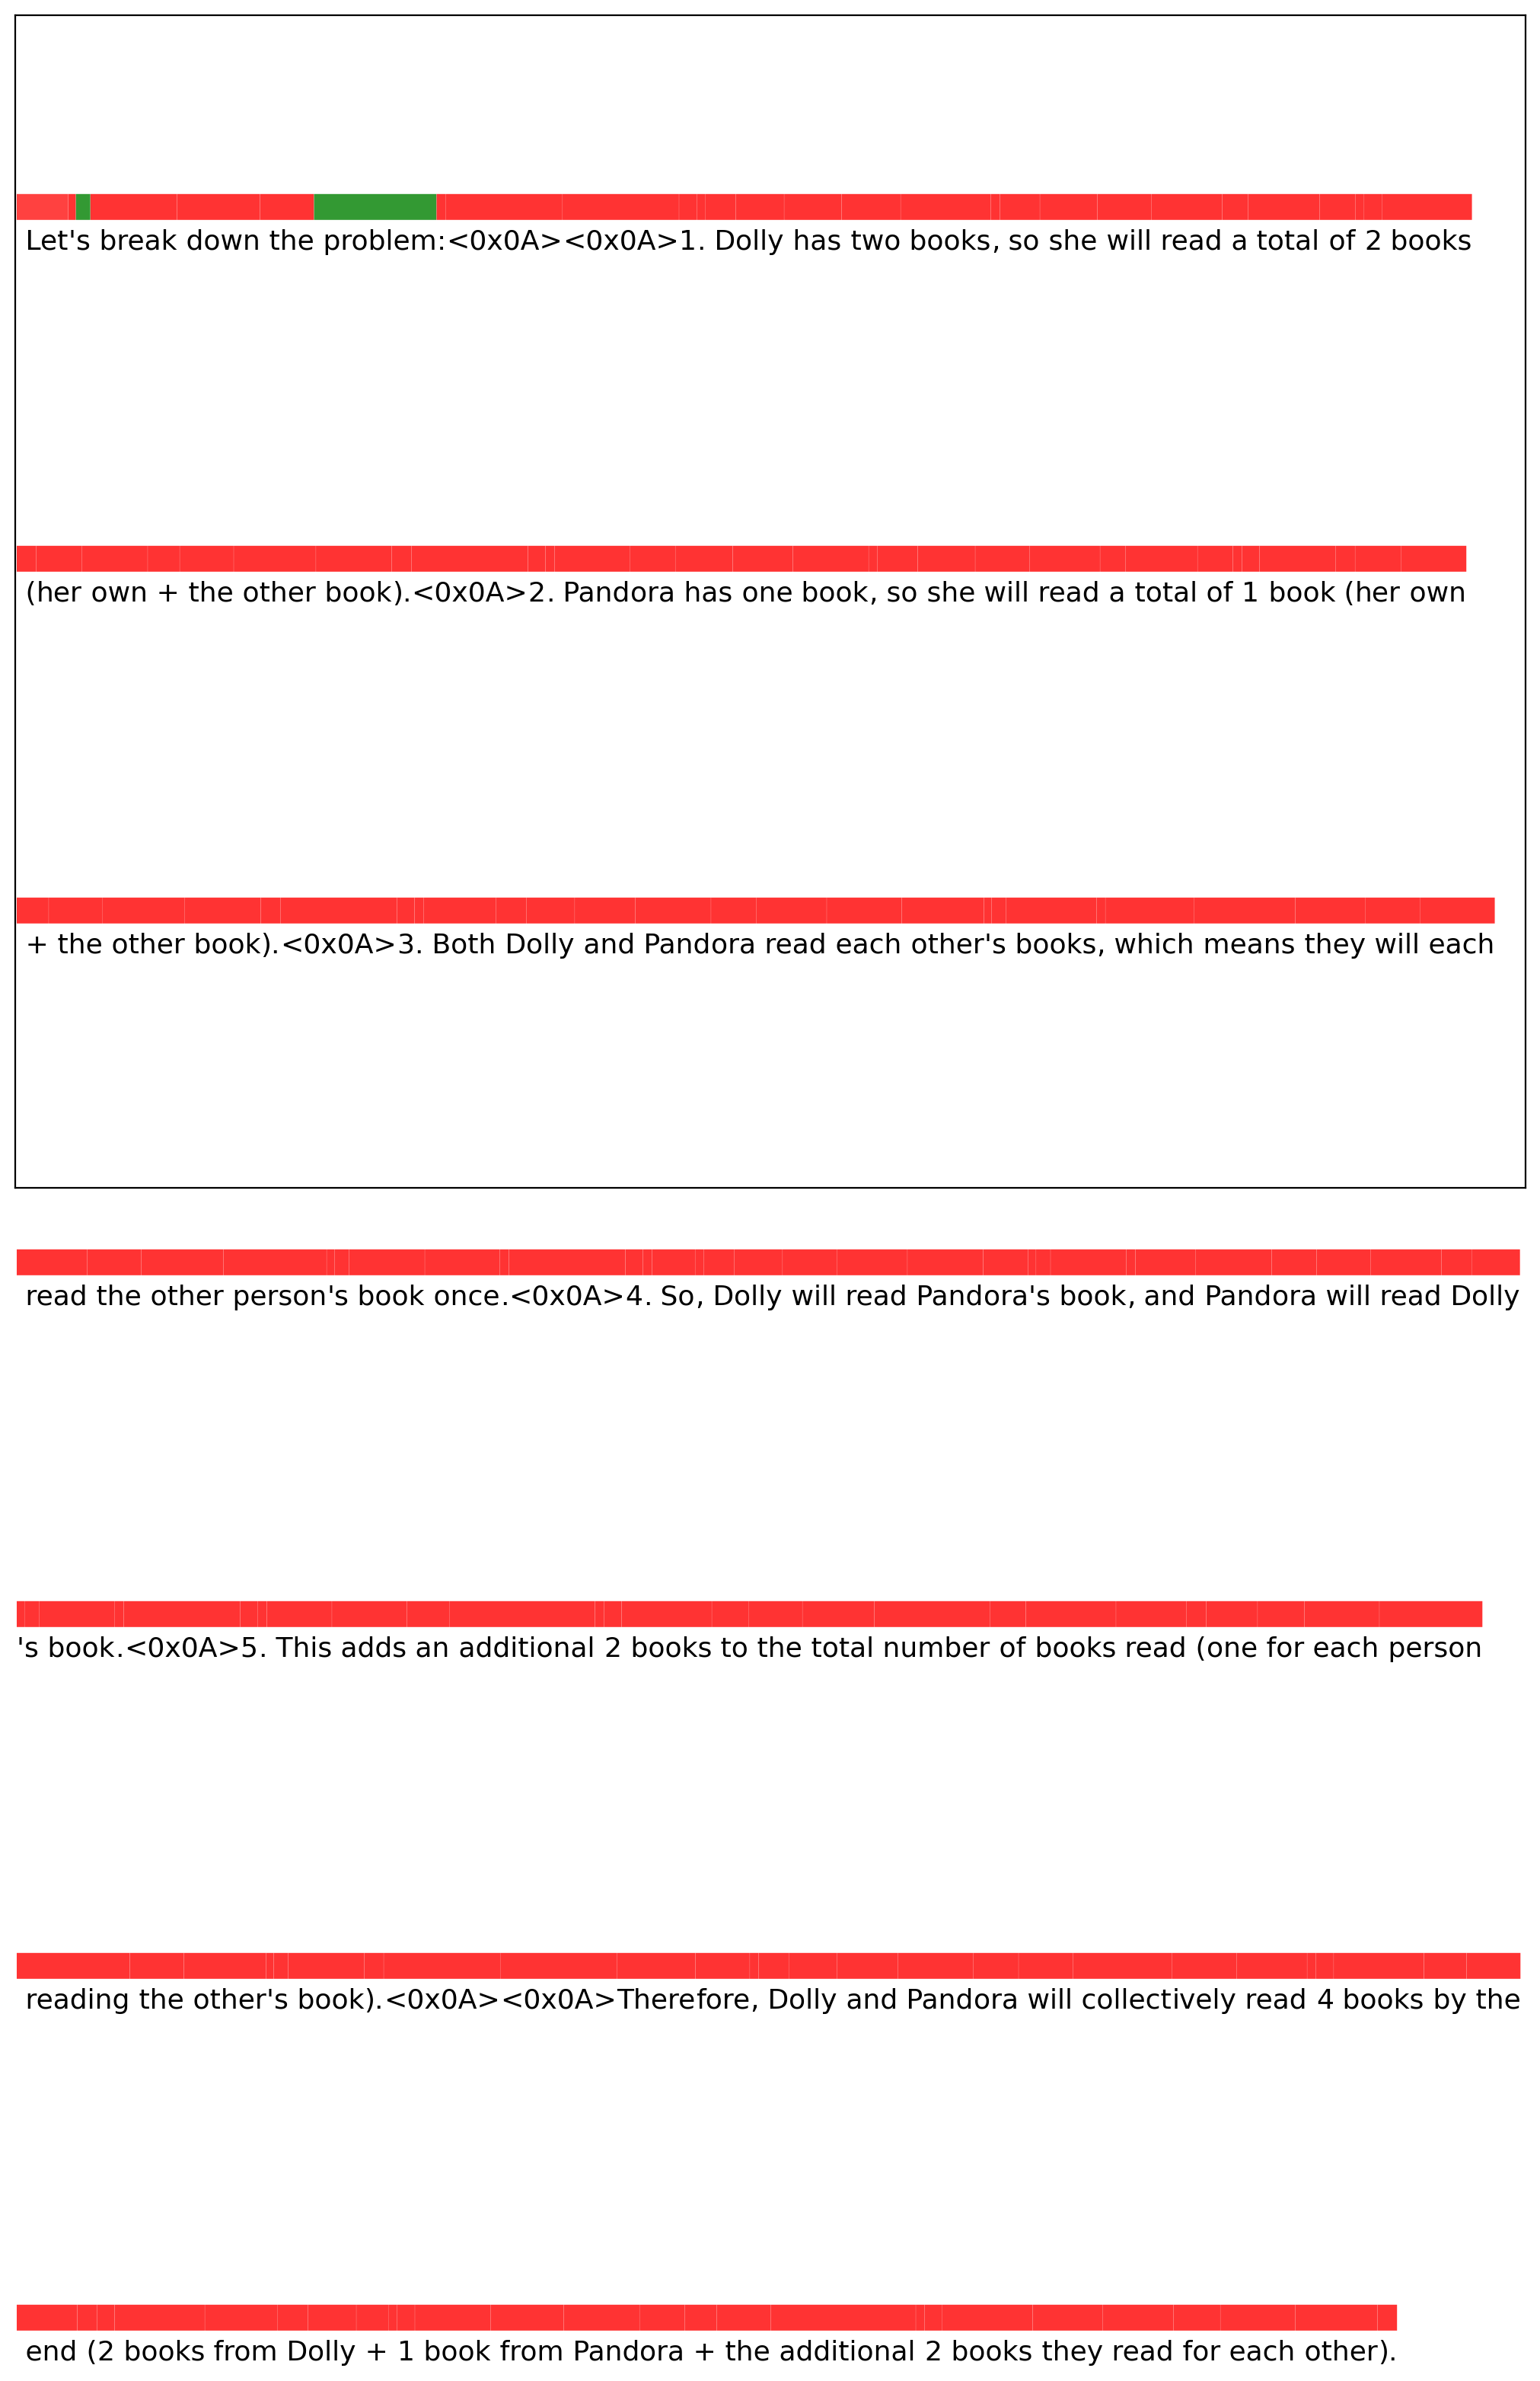

In [91]:
plot_detection_results(input_ids, rep_reader_scores_mean_dict, THRESHOLD, start_answer_token=tokenizer.tokenize(asst_tag)[-1])

In [92]:
plot_lat_scans(input_ids, rep_reader_scores_dict, layer_slice=slice(5, -5))

ValueError: '▁A' is not in list

In [93]:
# # Define the initial range of layers
# layer_id = list(range(-5, -17, -1))

# # Additional individual layers to add
# additional_layers = [-30]

# # Extend the layers list with the additional individual layers
# layer_id.extend(additional_layers)
layer_id = layers


block_name="decoder_block"
control_method="reading_vec"

rep_control_pipeline = pipeline(
    "rep-control", 
    model=model, 
    tokenizer=tokenizer, 
    layers=layer_id, 
    control_method=control_method)

In [95]:
inputs = [
    f"{user_tag}Q: Dolly has two books. Pandora has one. If both Dolly and Pandora read each others' books as well as their own, how many books will they collectively read by the end?\nA: {asst_tag}",
]

coeff=1.5
max_new_tokens=512

activations = {}
for layer in layer_id:
    activations[layer] = torch.tensor(coeff * cot_rep_reader.directions[layer] * cot_rep_reader.direction_signs[layer]).to(model.device).half()

baseline_outputs = rep_control_pipeline(inputs, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False)
control_outputs = rep_control_pipeline(inputs, activations=activations, batch_size=4, max_new_tokens=max_new_tokens, do_sample=False, repetition_penalty=1.0)

for i,s,p in zip(inputs, baseline_outputs, control_outputs):
    print("===== No Control =====")
    print(s[0]['generated_text'].replace(i, ""))
    print(f"===== + Careful Control =====")
    print(p[0]['generated_text'].replace(i, ""))
    print()

===== No Control =====
 Dolly will read 2 books, Pandora will read 1 book, and they will both read each other's books. So, Dolly will read Pandora's book and Pandora will read Dolly's book. Therefore, they will collectively read 2 + 1 + 2 = 5 books.
===== + Careful Control =====
It is not clear how many books Dolly and Pandora will collectively read by the end.

